# Convergence comparison of ptycho algorithms

## Introduction

In this notebook, we are comparing the convergence of the three ptycho reconstruction algorithms: admm, combined, divided. The ADMM approach solves the ptychography nearplane, farplane, probe, and object subproblems jointly using ADMM. The divded approach solves each of the subproblems sequentially, but without regularization. The combined problem solves the object and probe subproblems with the nearplane and farplane problems integated.

We will plot the convergence of each these algorithms using various metrics including:

* primal residuals
* dual residuals
* augmented lagrangian
* relative error (to previous iteration) for all subproblems

## Convergence metrics

In this section, we define helper functions to compute all the convergence metrics.

In [1]:
import numpy as np

In [2]:
def constraint_farplane(operator, nearplane, farplane, **kwargs):
    return operator.propagation.fwd(nearplane) - farplane

def primal_farplane(operator, nearplane, farplane, **kwargs):
    return np.linalg.norm(constraint_farplane(operator, nearplane, farplane))**2

def constraint_nearplane(operator, probe, psi, nearplane, scan, **kwargs):
    return operator.diffraction.fwd(probe=probe, psi=psi, scan=scan) - nearplane

def primal_nearplane(operator, probe, psi, nearplane, **kwargs):
    return np.linalg.norm(constraint_nearplane(operator, probe, psi, nearplane, **kwargs))**2

In [3]:
# dual residuals are same as relative error for farplane and nearplane?

In [4]:
data_frames = np.load('cg04/data.npy')  # same data for any cg_iter
def augmented_lagrangian(operator, farplane, nearplane, psi, probe, λ, μ, ρ, τ, **kwargs):
    return (
        + operator.propagation.cost(data_frames, farplane)
        + 2 * np.sum(np.real(np.conj(λ) * constraint_farplane(operator, nearplane, farplane, **kwargs)))
        + ρ * primal_farplane(operator, nearplane, farplane, **kwargs)
        + 2 * np.sum(np.real(np.conj(μ) * constraint_nearplane(operator, probe, psi, nearplane, **kwargs)))
        + τ * primal_nearplane(operator, probe, psi, nearplane, **kwargs)
    )

In [5]:
def relative_error(x0, x1):
    return np.linalg.norm(x0 - x1)**2 / np.linalg.norm(x0)**2

## Compute the metrics

In this section, we load the data from the disk and compute the metrics.

In [6]:
import tike.operators
op = tike.operators.Ptycho(
    detector_shape=15*2,
    probe_shape=15,
    nscan=21*21,
    nz=128,
    n=128,
)

In [7]:
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import tifffile

all_metrics = {}

for folder in ['cg04', 'cg10']:
    for algorithm in ['admm', 'admm1', 'combined', 'divided']:
        metrics = defaultdict(list)
        files = sorted(glob.glob(f'{folder}/{algorithm}.*.npz'))
        data0 = []
        for i in range(len(files)):
            print(files[i])
            ii = int(files[i].split('.')[1])
            metrics['i'].append(ii)

            data = np.load(files[i])

            tifffile.imsave(f'{folder}/p/{algorithm}.{ii:03d}.tiff', np.angle(data['psi'][0]).astype('float32'))
            tifffile.imsave(f'{folder}/a/{algorithm}.{ii:03d}.tiff', np.abs(data['psi'][0]).astype('float32'))

            metrics['time'].append(data['time'] if ii > 0 else 0)

            if 'farplane' in data and 'nearplane' in data:
                metrics['primal_farplane'].append(primal_farplane(op, **data))
            else:
                metrics['primal_farplane'].append(None)

            if 'nearplane' in data:
                metrics['primal_nearplane'].append(primal_nearplane(op, **data))
            else:
                metrics['primal_nearplane'].append(None)

            if 'λ' in data and 'farplane' in data:
                metrics['augmented_lagrangian'].append(augmented_lagrangian(op, ρ=0.5, τ=0.5, **data))
            else:
                metrics['augmented_lagrangian'].append(None)

            for param in ['psi', 'probe']:
                if param in data and param in data0:
                    metrics[f'Δ {param}'].append(relative_error(data0[param], data[param]))
                else:
                    metrics[f'Δ {param}'].append(None)

            data0 = data

        all_metrics[f"{algorithm}-{folder}"] = metrics

cg04/admm.000.npz
cg04/admm.001.npz
cg04/admm.002.npz
cg04/admm.003.npz
cg04/admm.004.npz
cg04/admm.005.npz
cg04/admm.006.npz
cg04/admm.007.npz
cg04/admm.008.npz
cg04/admm.009.npz
cg04/admm.011.npz
cg04/admm.012.npz
cg04/admm.014.npz
cg04/admm.016.npz
cg04/admm.018.npz
cg04/admm.021.npz
cg04/admm.024.npz
cg04/admm.027.npz
cg04/admm.031.npz
cg04/admm.035.npz
cg04/admm.040.npz
cg04/admm.045.npz
cg04/admm.051.npz
cg04/admm.058.npz
cg04/admm.066.npz
cg04/admm.075.npz
cg04/admm.086.npz
cg04/admm.097.npz
cg04/admm.111.npz
cg04/admm.126.npz
cg04/admm.143.npz
cg04/admm.162.npz
cg04/admm.184.npz
cg04/admm.210.npz
cg04/admm.238.npz
cg04/admm.270.npz
cg04/admm.307.npz
cg04/admm.349.npz
cg04/admm.396.npz
cg04/admm.450.npz
cg04/admm.512.npz
cg04/admm1.000.npz
cg04/admm1.001.npz
cg04/admm1.002.npz
cg04/admm1.003.npz
cg04/admm1.004.npz
cg04/admm1.005.npz
cg04/admm1.006.npz
cg04/admm1.007.npz
cg04/admm1.008.npz
cg04/admm1.009.npz
cg04/admm1.011.npz
cg04/admm1.012.npz
cg04/admm1.014.npz
cg04/admm1.016.

## Plot the metrics

In [75]:
import matplotlib.pyplot as plt
from cycler import cycler

np.random.seed(1)
default_cycler = (
    cycler(color=[plt.cm.viridis((x%4)/4) for x in range(8)]) +
    cycler(linestyle=[(0, np.random.randint(1, 4, size=4)) for x in range(8)])
)
plt.rc('axes', prop_cycle=default_cycler)

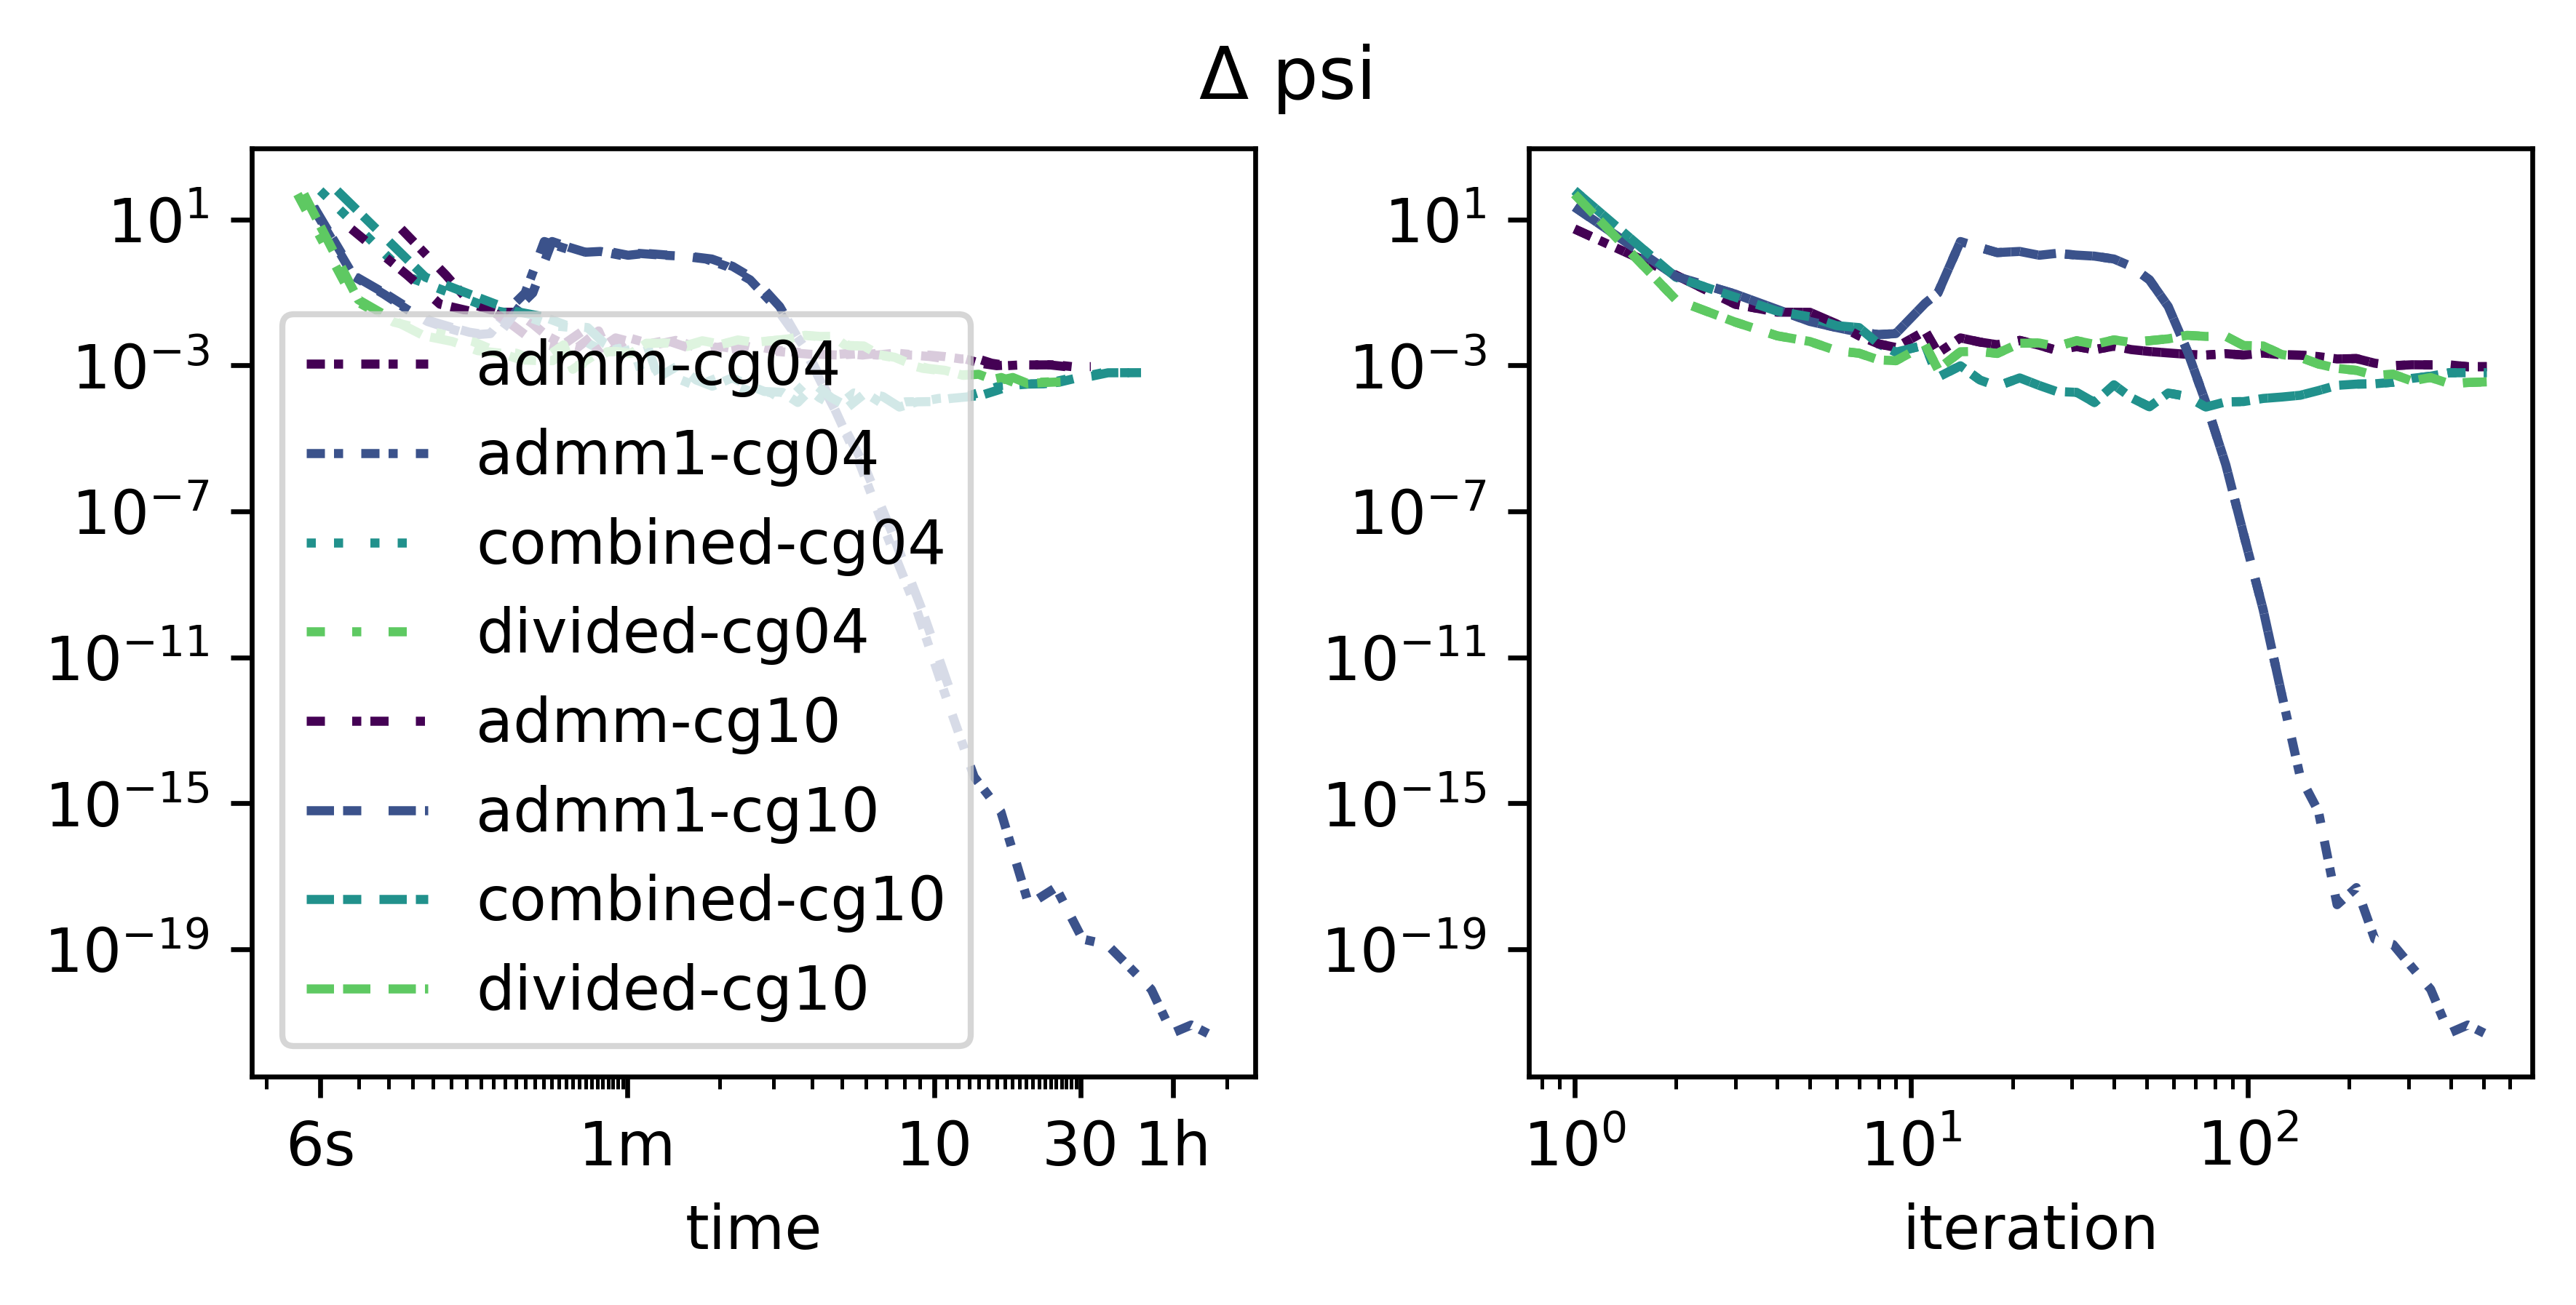

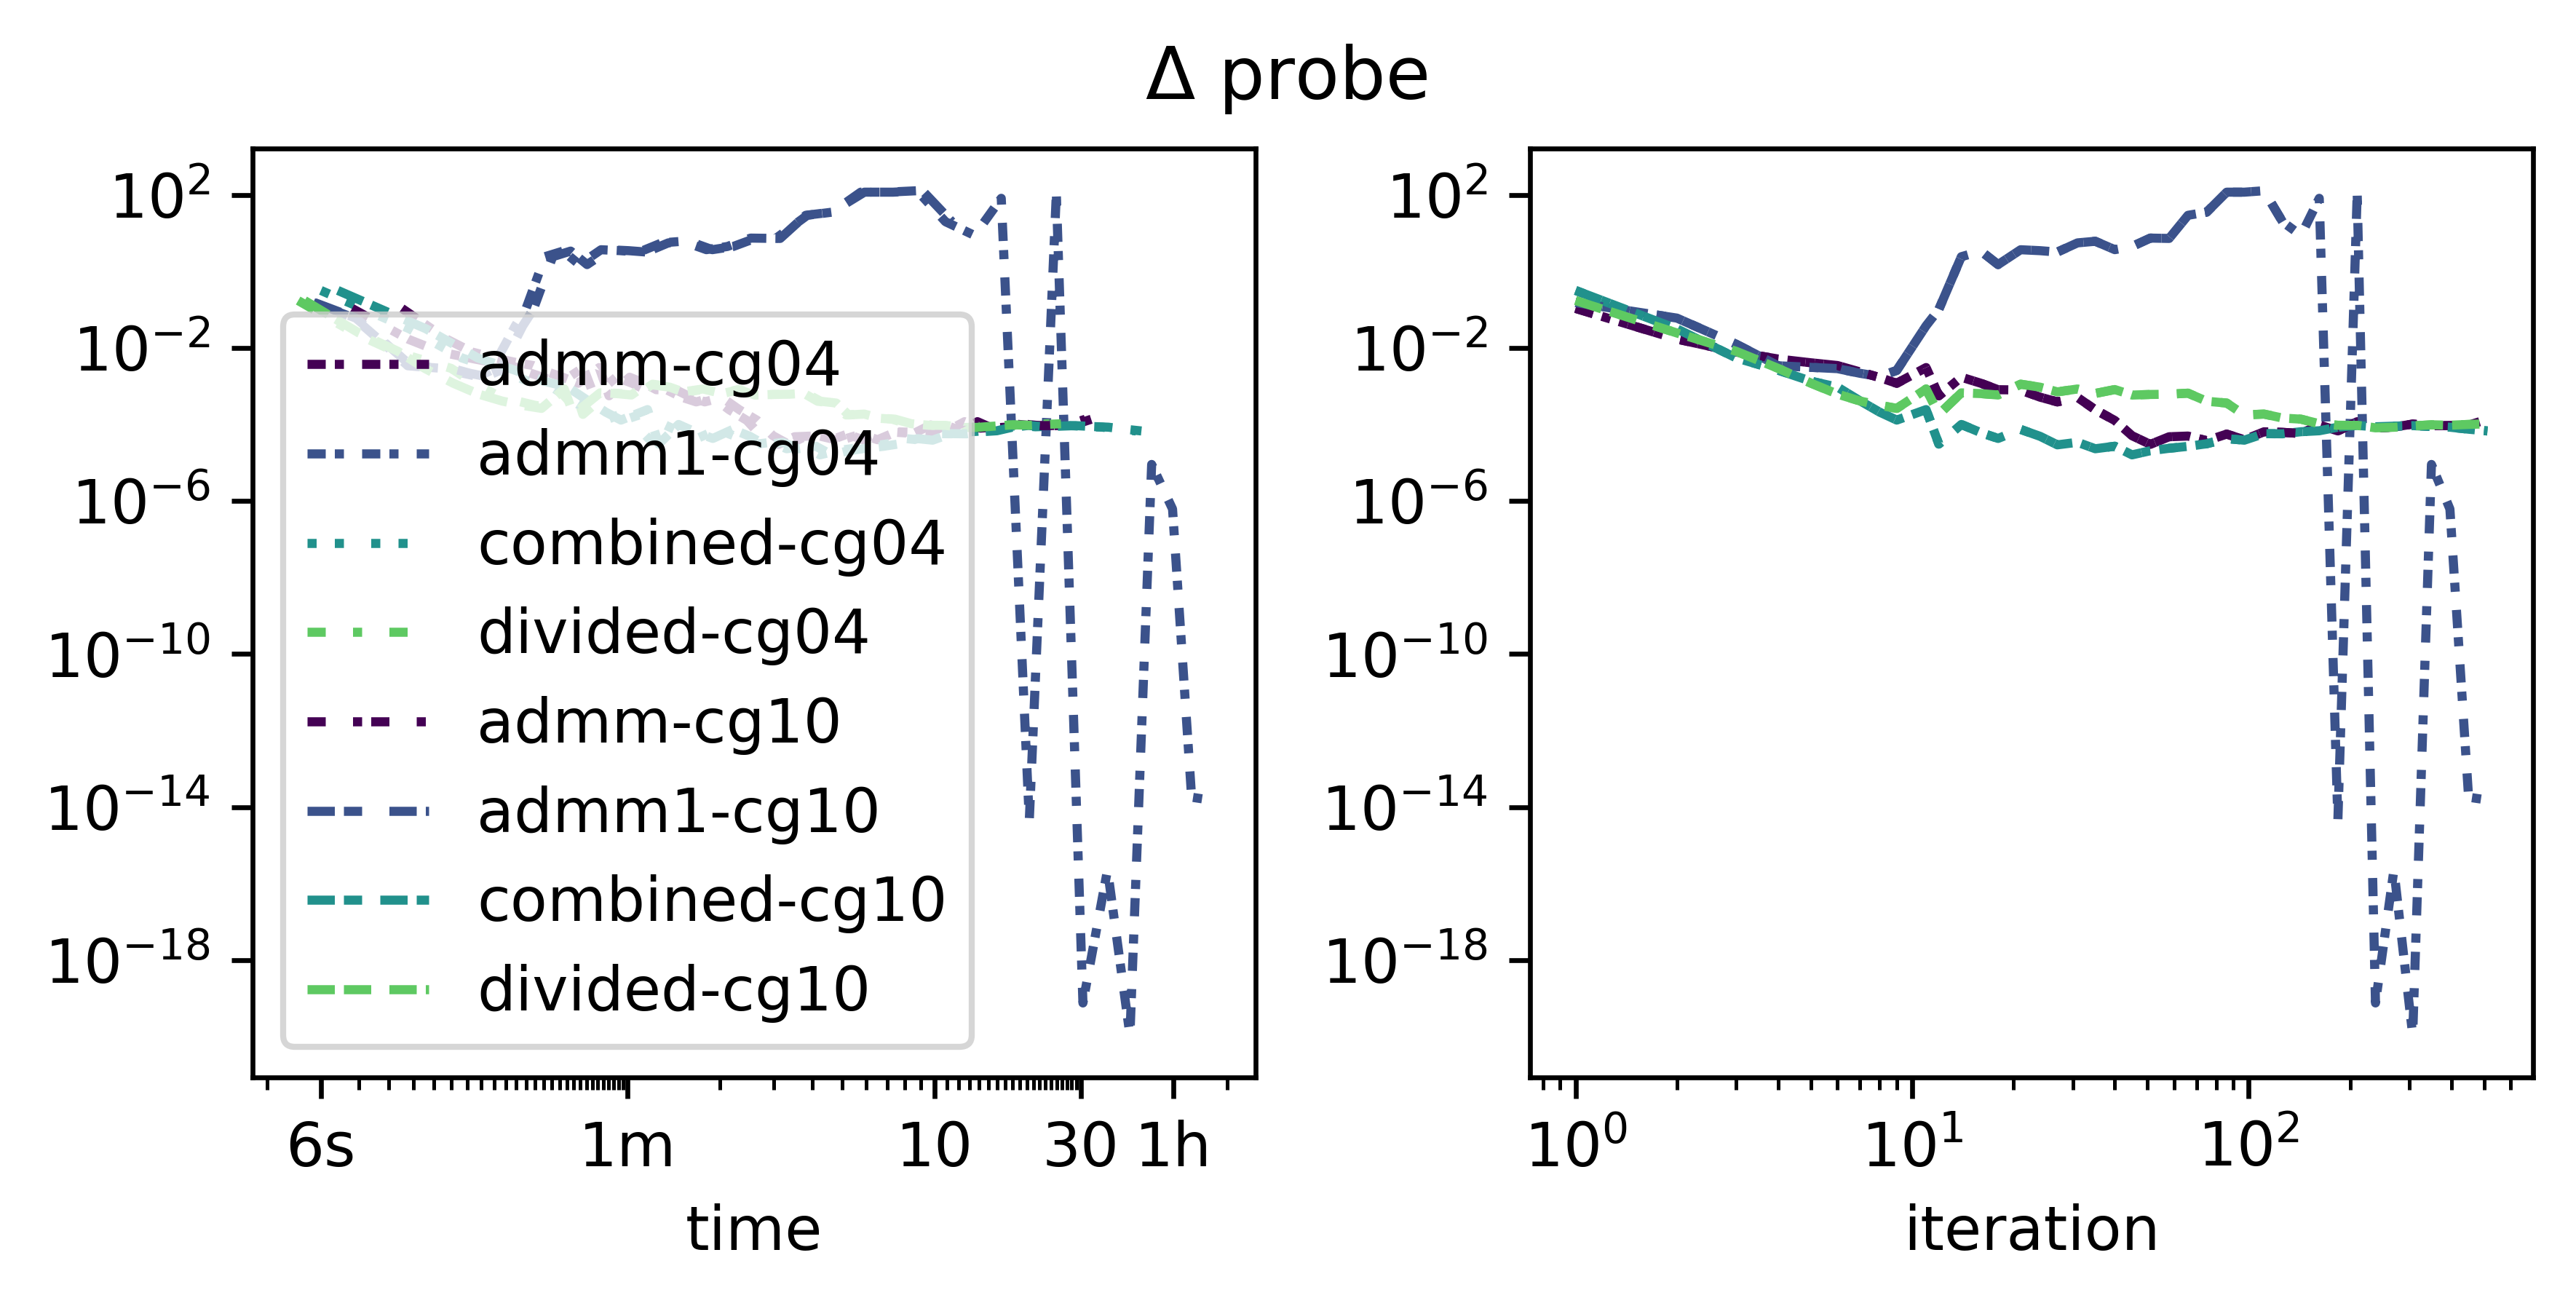

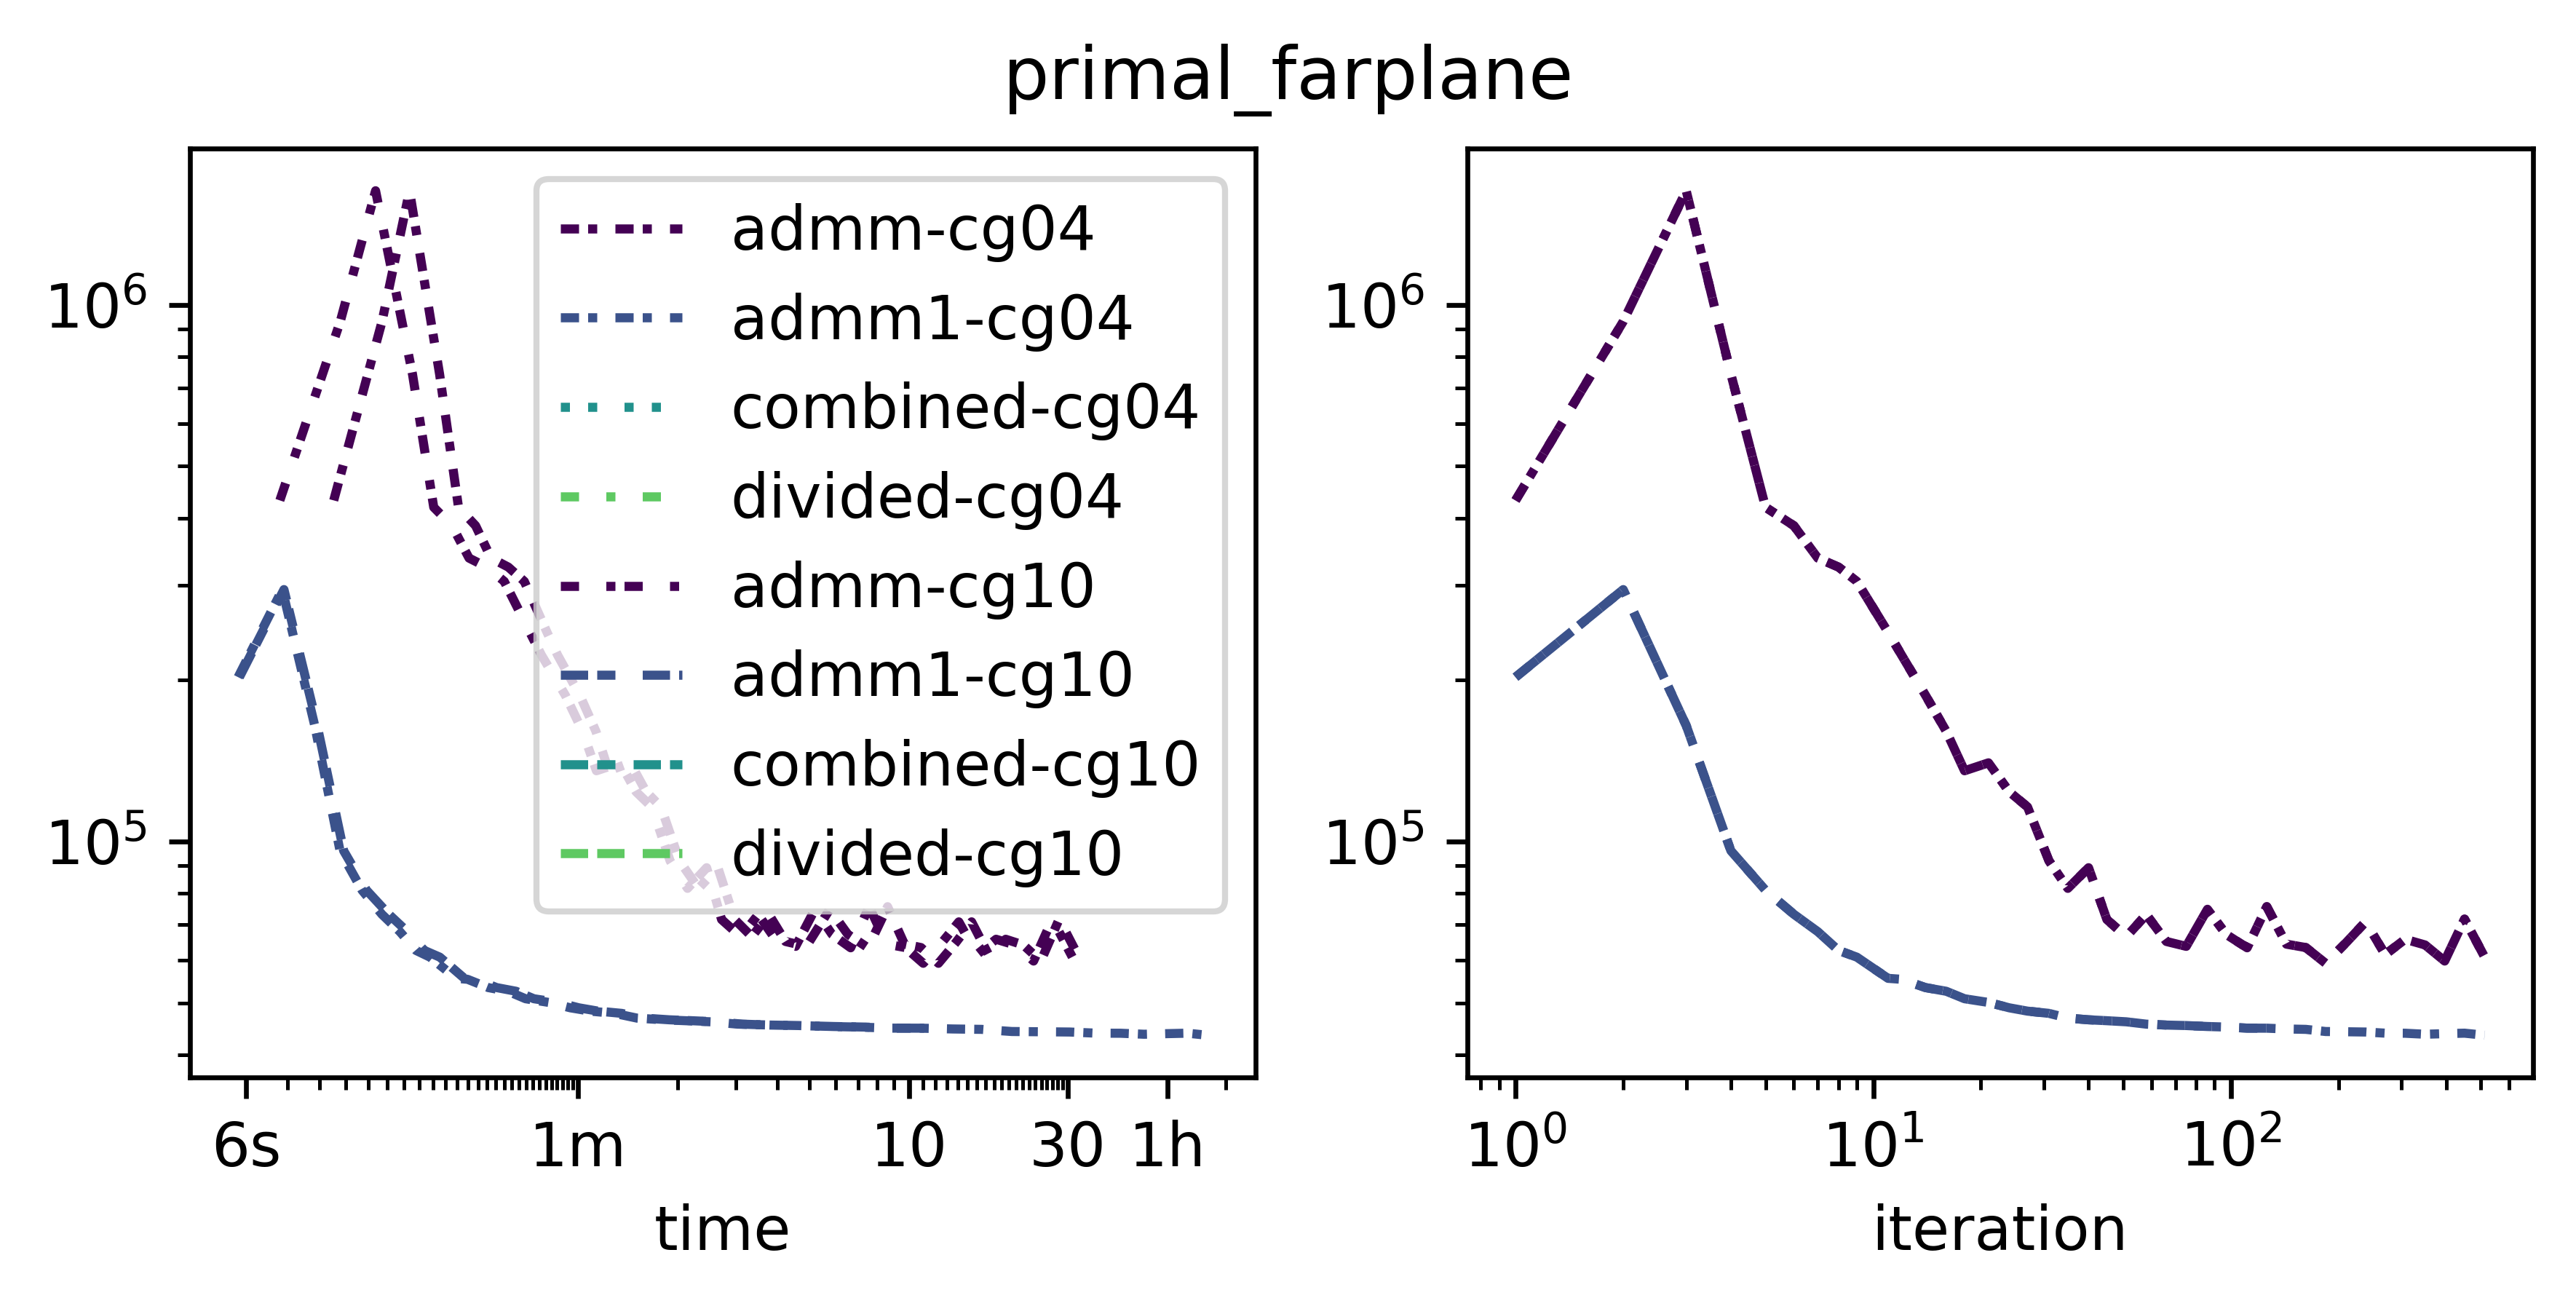

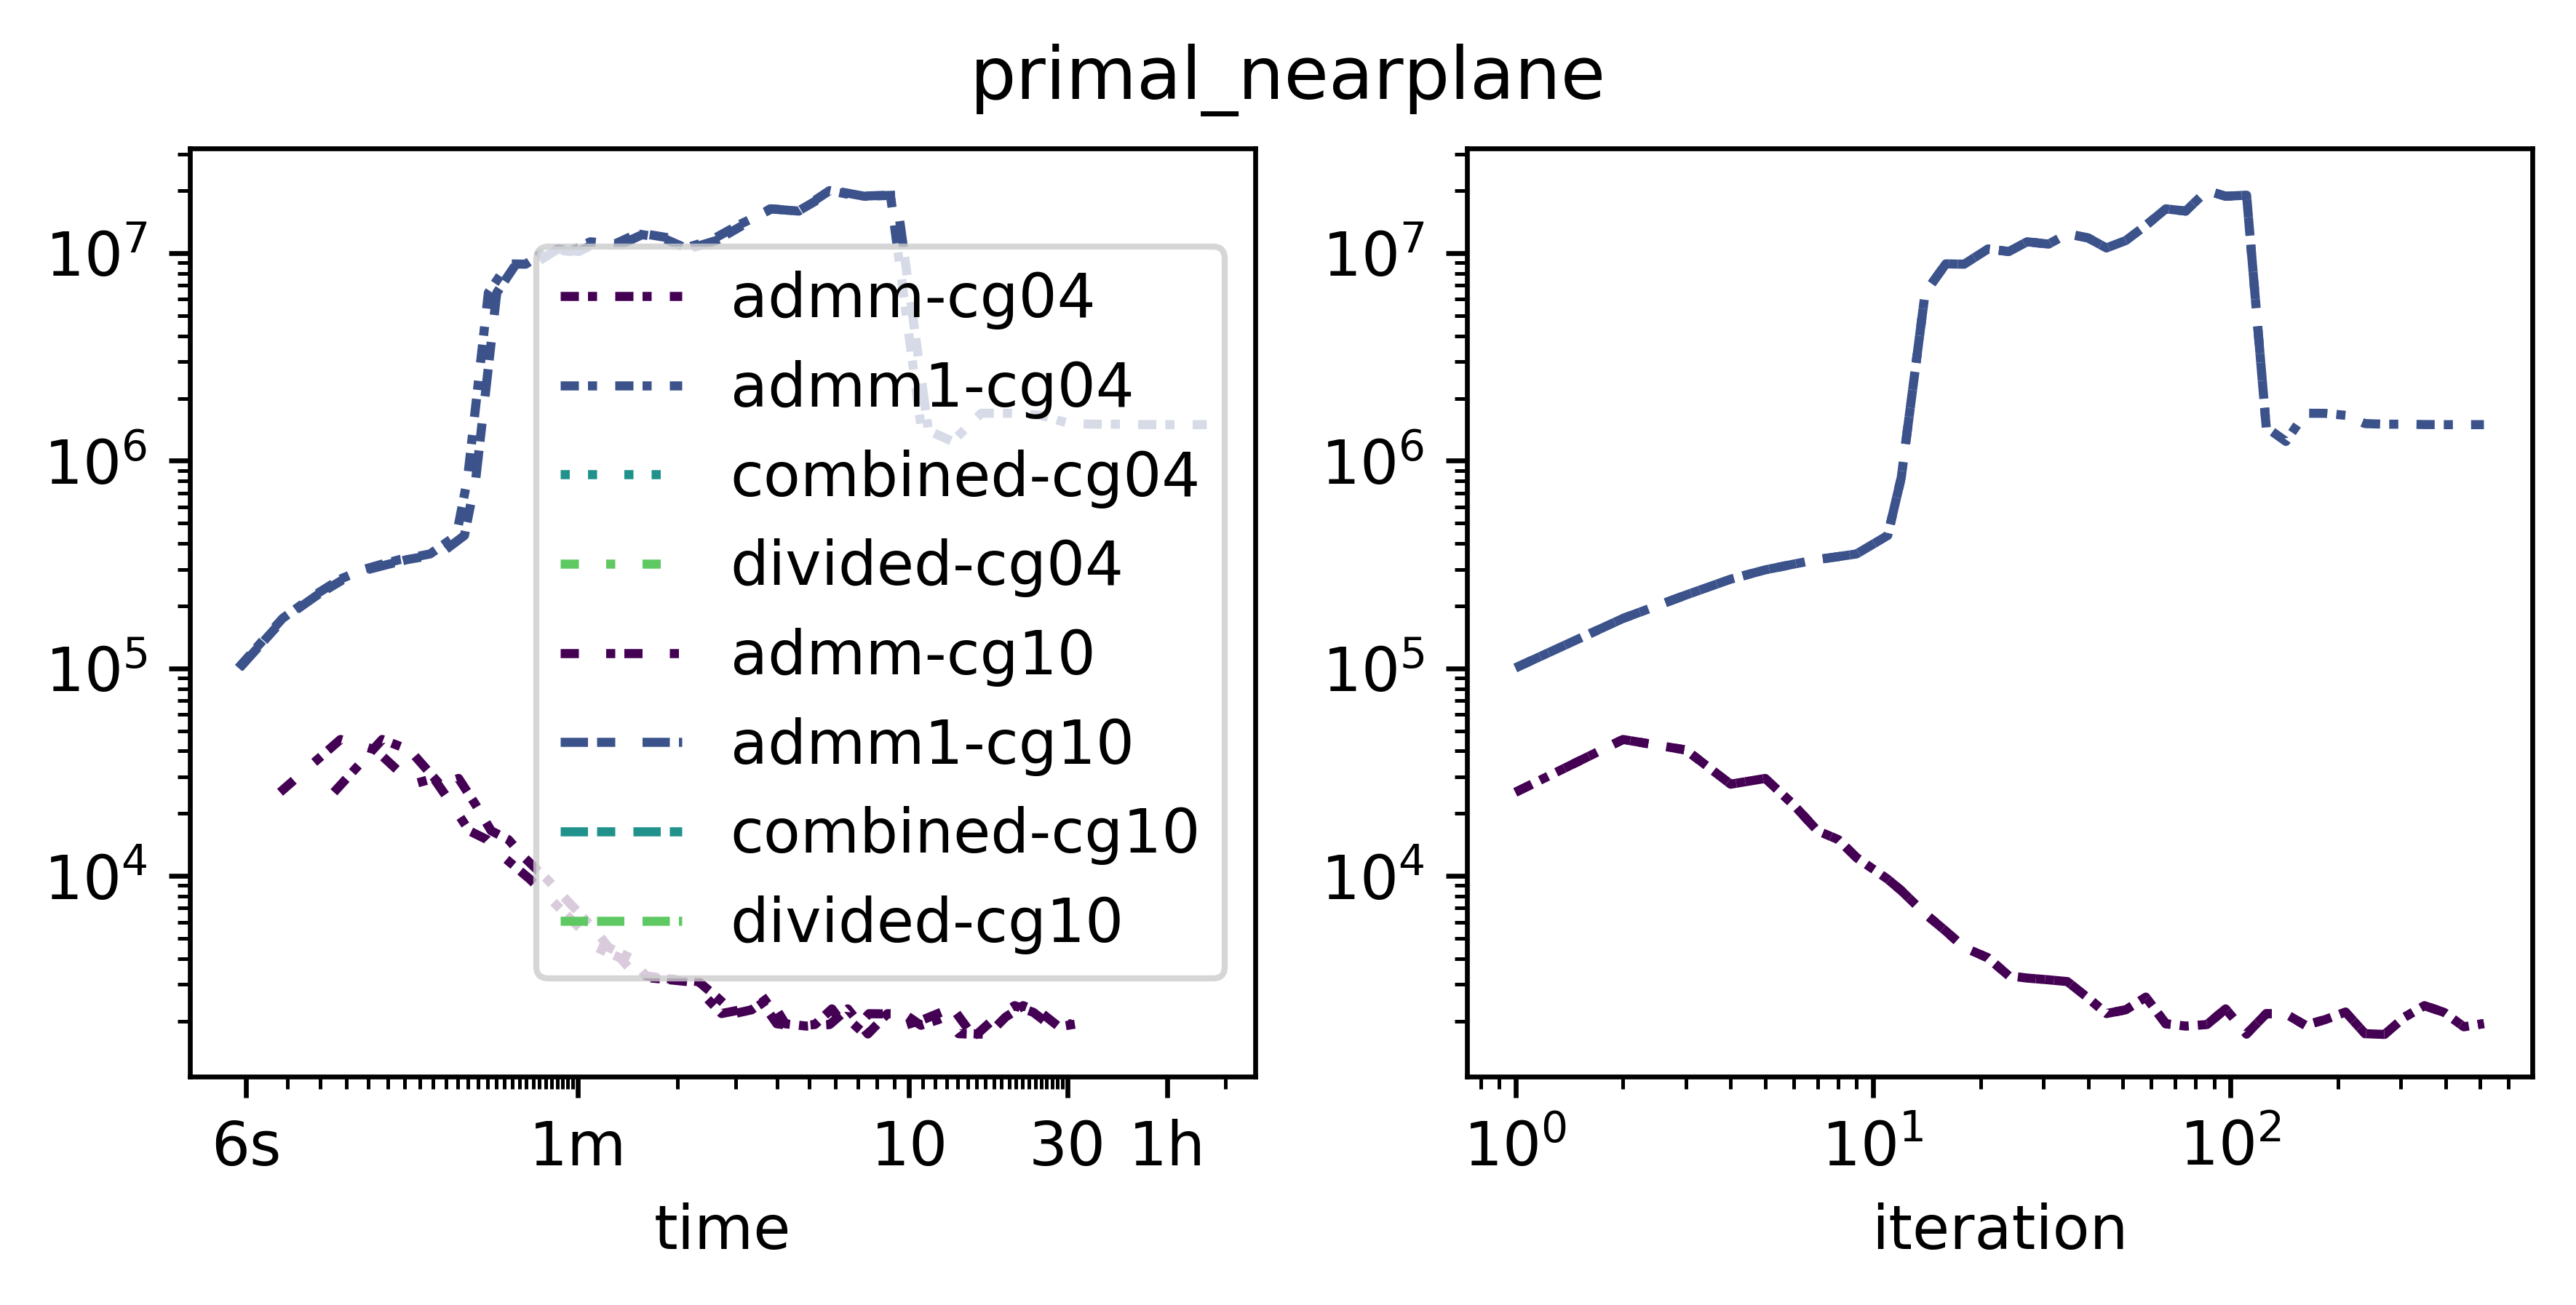

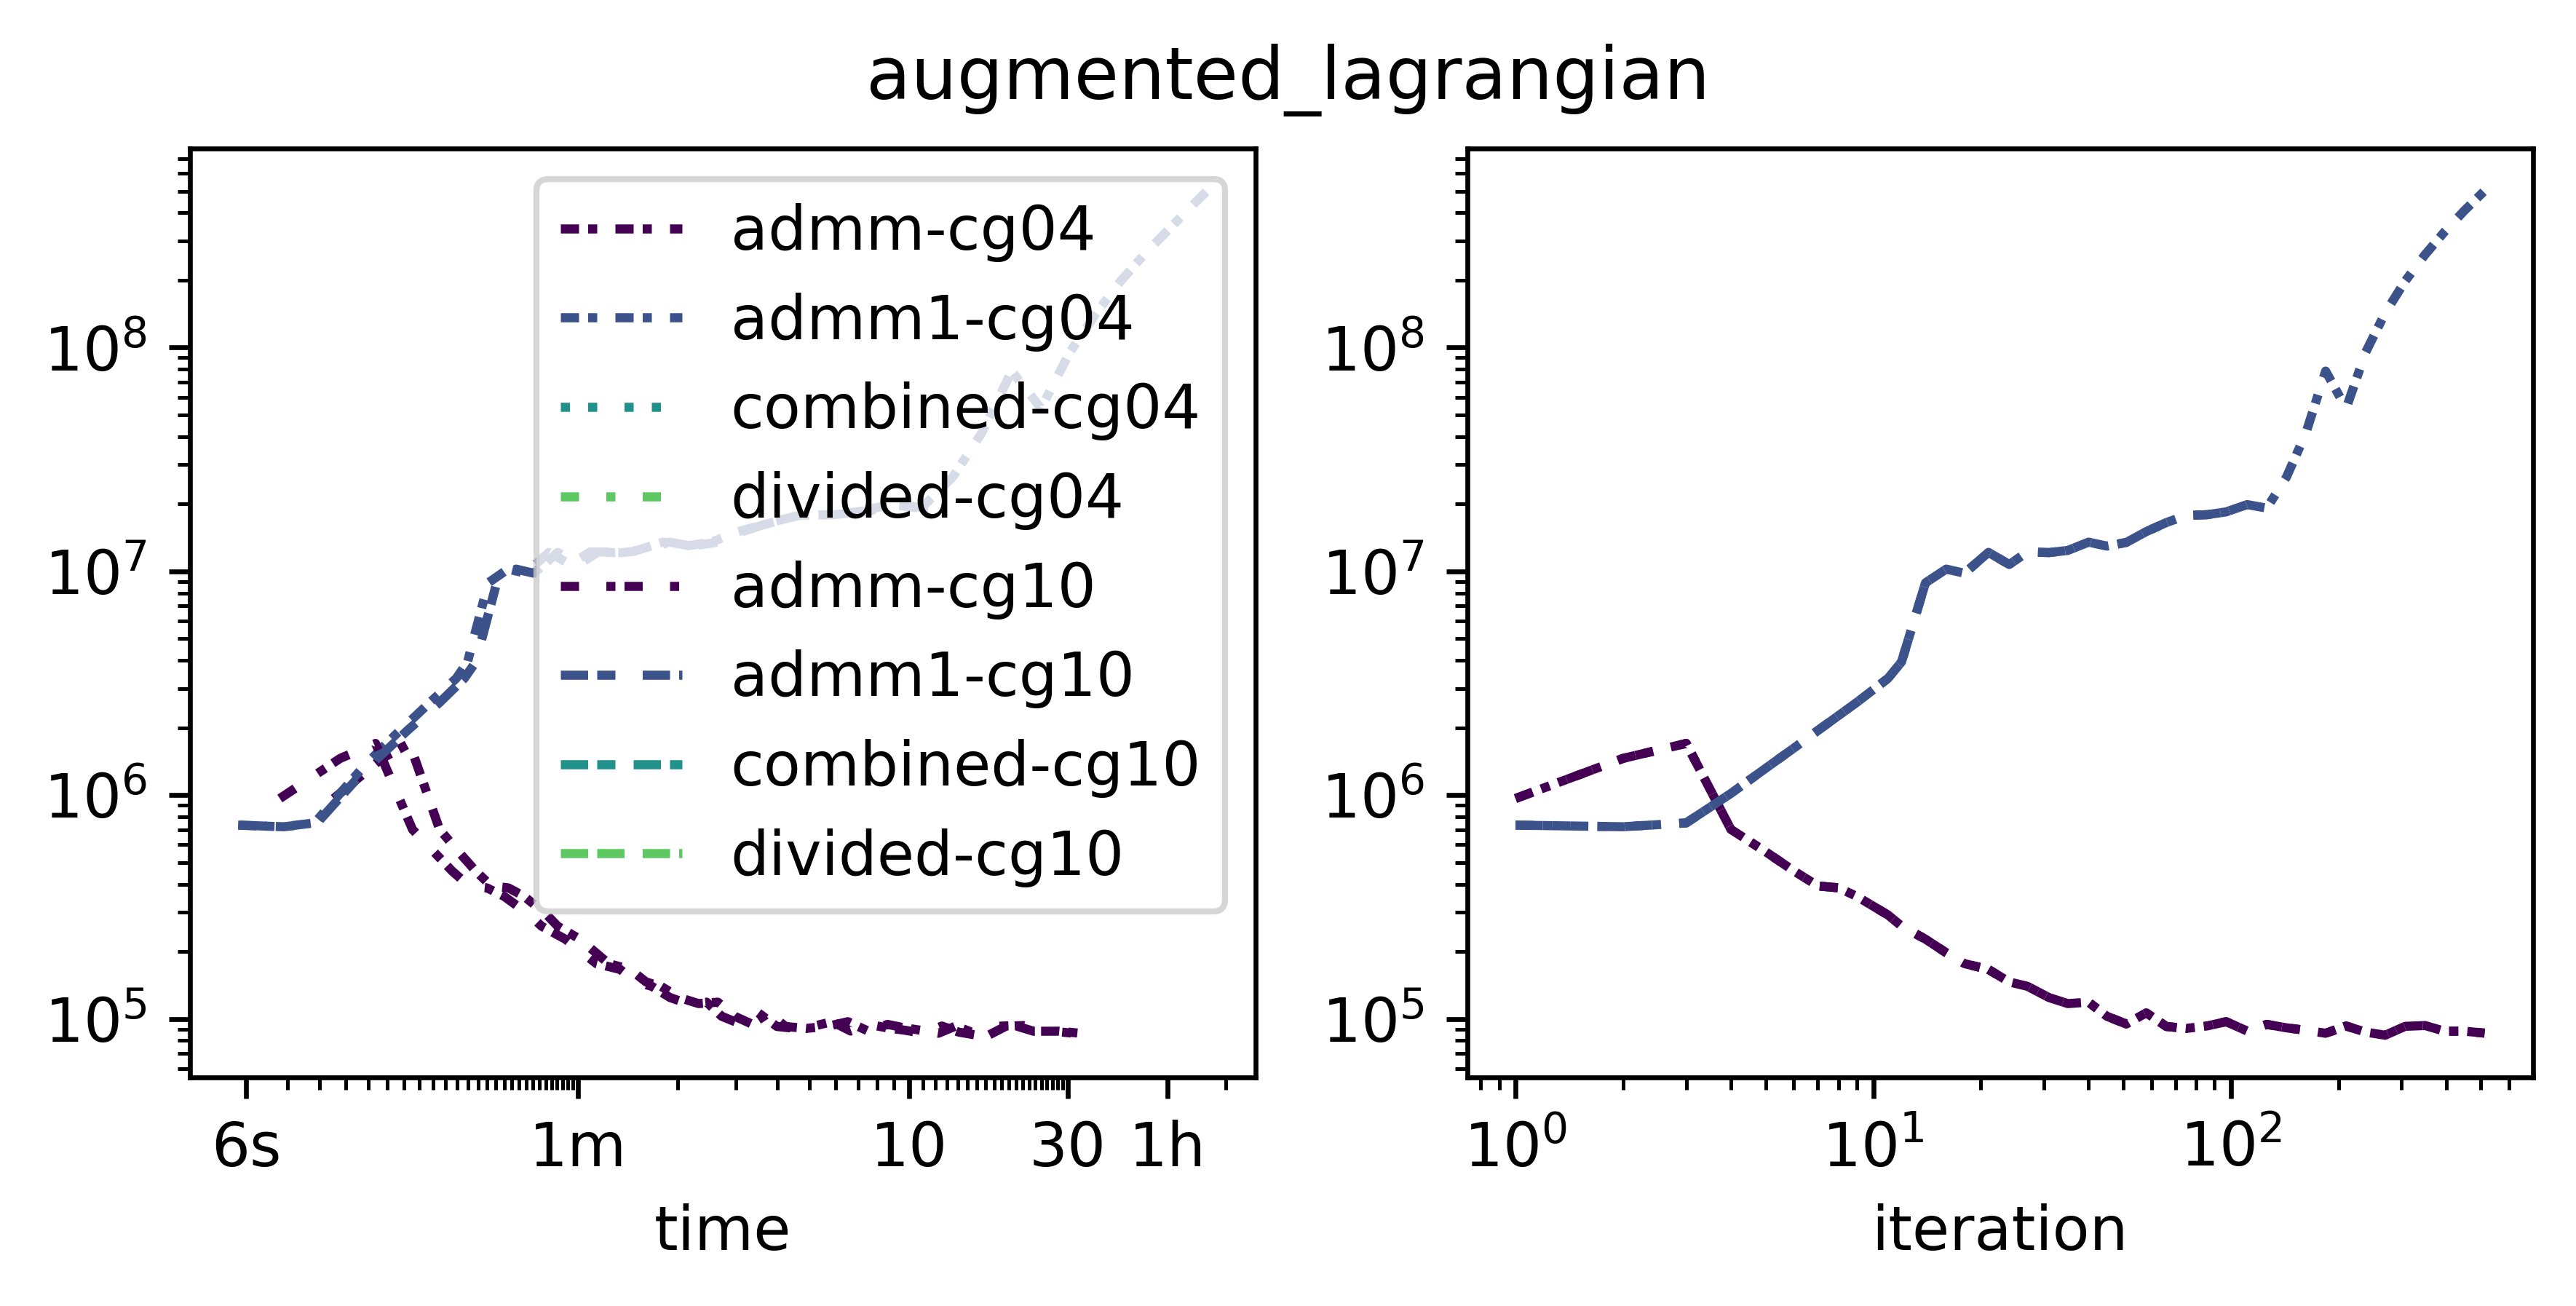

In [77]:
for key in ['Δ psi', 'Δ probe', 'primal_farplane', 'primal_nearplane', 'augmented_lagrangian']:
    if key in ['i', 'time']:
        continue
    plt.figure(dpi=600, figsize=(6, 3))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    l = []
    for algorithm in all_metrics:
        if key in all_metrics[algorithm]:
            ax1.loglog(
                np.array(all_metrics[algorithm]['time']) / 60, all_metrics[algorithm][key],
                basex=30,
            )
            ax2.loglog(
                np.array(all_metrics[algorithm]['i']), all_metrics[algorithm][key],
            )
            l.append(algorithm)
    ax1.legend(l)
    plt.suptitle(key)
    ax1.set_xlabel('time')
    ax1.set_xticks([6/60, 1, 10, 30, 60])
    ax1.set_xticklabels(['6s', '1m', '10', '30', '1h'])
    ax2.set_xlabel('iteration')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f'{key}.svg')
    plt.show()